# Neural Structured Learning on Time Series
Two novelties are implemented in this notebook:
* Use the GraphNet framework for time-series in order to discover and exploit degradation trends in the same experiment
* Use implicit reparametrization gradients to learn with SGD the parameters of a gamma distribution instead of an empirical error on the output. This is closer to reality and should work better.


## Load data:

In [5]:
from collections import OrderedDict

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)

import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive


import pandas as pd


/home/charilaos/.local/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [6]:


import os
all_files = [f for f in os.listdir(os.path.join('bearing_fatigue_dataset')) if 'pickle' in f]

load_from_disk = False;
load_first_stage = True
if load_from_disk:
    def load_bearings_dataset(all_files = all_files):
        fnames = all_files
        exp_ids_tot = [];
        yrem_tot = [];
        sensor_values_tot = []

        for kk,fname in enumerate(fnames):
            p1 = pd.read_pickle("bearing_fatigue_dataset/%s"%fname)
            p1['abs_timestamp'] = (p1['h']*60+p1['m'])*60+p1['s']+p1['se-6']/1e6
            
            sensors = p1.groupby("block").apply(lambda x : [x['abs_timestamp'].mean(),np.vstack([x['h_acc'].values, x['v_acc'].values]).T])
            sens_val = np.dstack([v[1] for v in sensors.values])
            sensor_values = np.swapaxes(np.swapaxes(sens_val,0,-1),1,2).astype('float32')
            print(sensor_values.shape)

            yrem = np.vstack([v[0] for v in sensors.values]).astype('float32')
            yrem = np.abs(yrem - np.max(yrem))

            exp_id = np.hstack([kk for v in range(yrem.shape[0])])

            sensor_values_tot.append(sensor_values)
            exp_ids_tot.append(exp_id);
            yrem_tot.append(yrem)

            print(kk)

        yrem_tot = np.vstack(yrem_tot).flatten()
        eid = np.hstack(exp_ids_tot).flatten()
        X__ = np.vstack(sensor_values_tot)
        return yrem_tot, eid, X__
    yrem_s_raw, eid, X = load_bearings_dataset()
    
if load_first_stage:
    L = np.load("first_stage_preproc_bearings.npz")
    yrem_s_raw, X, eid = [L[l] for l in L.files]

In [7]:
#help(np.savez) #yrem_s_raw
# np.savez("first_stage_preproc_bearings",yrem_s_raw,X,eid )



## Train/Test splitting
* I need a strong validation set where whole experiments are completely unseen during training.
* I suspect some early interruptions of the experiments (that was from initial investigations). Some experiments ommited.

In [8]:

normalization_factor_time = 25000;
yrem_norm = yrem_s_raw/normalization_factor_time;

yrem_norm[yrem_norm<0.0001] = 0.0001

eid_oh = np.zeros([eid.shape[0],np.max(eid) + 1])
for k in np.unique(eid):
    eid_oh[eid == k,k] = 1.;

#yrem_norm = yrem / np.std(yrem);

#training_set_mask = 
conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
inds_exp_source =  [4,6,8,15,  9,10,0,7,  2,11]

conds_flag_target = [0,0,0,   1, 1, 1,  2]
inds_exp_target  = [1,5,16,  12,13,14,  3]


conds_flag = [*conds_flag_source, *conds_flag_target]
inds_experiments = [*inds_exp_source, *inds_exp_target]
exp_to_cond_dict = {k:v for k,v in zip(inds_experiments, conds_flag)}

loading_cond = [exp_to_cond_dict[k] for i,k in enumerate(np.argmax(eid_oh,1))]
loading_oh = np.zeros([eid_oh.shape[0],3])
for k in np.unique(loading_cond):
    loading_oh[loading_cond == k,k] = 1;


# conds_flag_source = [0,0,0,0,   1,1, 1,1,  2,2]
# inds_exp_source =  [4,6,8,15,  9,10,0,7,  2,11]

# conds_flag_target = [0,0,0,   1,  2]
# inds_exp_target  = [1,5,16,  12,  3]
    


inds_experiments = [*inds_exp_source, *inds_exp_target]

#############################################################
#Remove unused experiments:

ids_filter = [i for i,k in enumerate(np.argmax(eid_oh,1)) if k in inds_experiments]


X.shape,eid_oh.shape
#inds_exp_source
min_samples_keep = 1000;

exp_and_counts = [(kk,np.sum(eid_oh[:,kk] == 1)) for kk in range(len(inds_exp_source))]
inds_exp_source_new = [];
for e,i in exp_and_counts:
    if i>min_samples_keep:
        inds_exp_source_new.append(e)
#inds_exp_source
print(exp_and_counts)
inds_exp_source = inds_exp_source_new
#inds_exp_source = [2]
print(inds_exp_source)

[(0, 172), (1, 1502), (2, 1637), (3, 515), (4, 871), (5, 1802), (6, 2302), (7, 1202), (8, 1139), (9, 2002)]
[1, 2, 5, 6, 7, 8, 9]


In **GraphNets** I cannot simply randomly sample from different experiments. I need some code to make graph inputs for this dataset.

In [9]:
from fictitious_example.dataset_utils import *
from fictitious_example.minigraphnets import *

def data_from_experiment(eid, X_ = None, eid_oh_ = None, yrem_norm_ = None):
    ids = (np.argmax(eid_oh_,1) == eid)
    Xexp = X_[ids,:,:];
    yrem_exp_ = yrem_norm_[ids];
    return Xexp, yrem_exp_


def get_indices(ngraphs, ntotal_inds,n_seq_nodes, spacing_ratio = 0.5,
                nnode_range = None,nmax_node_range = 20, fixed_spacing_indices = None):
    """
    A function to sample increasting random indices from index sets.
    
    ngraphs         : how many index sets to sample
    
    ntotal_inds     : the indices of the series. 
    
    n_seq_nodes     : how many nodes should there be per index set sample
    
    spacing_ratio   : this controls how close or far away are the nodes sampled. The larger 
                      it is the further away the nodes are. Smaller than 1.
                      
    nnode_range     : (None) Alternatively from the `spacing_ratio` one can define the actual 
                      number of samples that are skipped.
    
    nmax_node_range : ...
    
    
    """
    
    if nmax_node_range is None:
        nmax_node_range = int(np.floor(ntotal_inds*spacing_ratio));
    
    if nnode_range is None:
        nnode_range = int(np.floor(nmax_node_range/n_seq_nodes));
        
    first_node_range = ntotal_inds - nmax_node_range;
    indices = [];
    
    n = np.random.choice(first_node_range,ngraphs);
        
    indices.append(n)
    for node_idx in range(n_seq_nodes-1):
        if fixed_spacing_indices is None:
            new_idx_shift = np.random.choice(nnode_range, ngraphs);
        else:
            new_idx_shift = fixed_spacing_indices
            
        indices.append(indices[-1] + new_idx_shift)
        
    indices = np.vstack(indices)
    return indices.T

def get_graph_data(experiment,  X_ = None, eid_oh_ = None, yrem_norm_ = None, 
                   n_sampled_graphs = 100, nnodes = 3, min_spacing = 20, max_spacing = 100, fixed_spacing = False, node_time_scaling = 5.):
     
        
    
    fixed_spacing_indices = None
    if fixed_spacing:
        fixed_spacing_indices = min_spacing
    
        
    # For computational efficiency the number of nodes and edges in each graph is the same. 
    # For efficiency in creating the dataset, the nodes and edges are also created in parallel.
    exp_dat = data_from_experiment(experiment, X_ = X_, eid_oh_ = eid_oh_, yrem_norm_ = yrem_norm_)
    ntotal_inds = exp_dat[0].shape[0];
    inds = get_indices(n_sampled_graphs, ntotal_inds, nnodes, fixed_spacing_indices = fixed_spacing_indices)
    X__, y__ = exp_dat;
    node_attr  = [X__[inds_,...] for inds_ in inds.T];
    node_times = [y__[inds_]*node_time_scaling for inds_ in inds.T]; # to be used for making attributes for the edges.
    nodes= [Node(node_attr_) for node_attr_ in node_attr];
    
    ## Connect all edges with all previous edges:
    edges = []
    for i in range(len(nodes)):
        node_to_idx = i
        
        if node_to_idx == 0:
            next #first node does not have an incoming node.
            
        for node_from_idx in range(0, node_to_idx):
            y_from, y_to = [node_times[ni] for ni in [node_from_idx, node_to_idx]]
            edge_attr = y_to - y_from
            #print("node_from/to: %i %i"%(node_from_idx, node_to_idx))
            edges.append(Edge(edge_attr[:,np.newaxis], node_from = nodes[node_from_idx], node_to = nodes[node_to_idx]));
    g__ =Graph(nodes,edges)
    g__.node_times = node_times
    g__.inds = inds
    return g__,node_times[-1] #Returns a graph and a prediction for the time at the graph's destination node.
    
    

def get_graph_data_multiple_experiments(experiments,X_ = None, eid_oh_ = None, yrem_norm_ = None,
                                        nsamples_per_experiment = 100,nnodes = 3, min_spacing = 20, max_spacing = 100, 
                                       fixed_spacing = False):
    all_graph_data = []
    for e in experiments:
        g = get_graph_data(e,  X_ = X_, eid_oh_ = eid_oh_,
                           yrem_norm_ = yrem_norm_,n_sampled_graphs = nsamples_per_experiment,
                          nnodes = nnodes, min_spacing = min_spacing, max_spacing = max_spacing,fixed_spacing = fixed_spacing)
        all_graph_data.append(g)
    return all_graph_data

get_graph_data(0, X_ = X, eid_oh_=eid_oh, yrem_norm_= yrem_norm, nnodes = 4)
    

(<fictitious_example.minigraphnets.Graph at 0x7f1b9c56b208>,
 array([0.09      , 0.32000002, 0.292     , 0.054     , 0.24000001,
        0.334     , 0.264     , 0.094     , 0.264     , 0.288     ,
        0.144     , 0.31      , 0.236     , 0.048     , 0.14999999,
        0.058     , 0.08000001, 0.14      , 0.096     , 0.09      ,
        0.21400002, 0.138     , 0.142     , 0.212     , 0.106     ,
        0.164     , 0.29999998, 0.19999999, 0.308     , 0.118     ,
        0.16000001, 0.058     , 0.16000001, 0.174     , 0.184     ,
        0.208     , 0.08000001, 0.104     , 0.144     , 0.232     ,
        0.08000001, 0.036     , 0.23      , 0.294     , 0.168     ,
        0.07      , 0.31800002, 0.072     , 0.19999999, 0.208     ,
        0.046     , 0.176     , 0.218     , 0.292     , 0.234     ,
        0.098     , 0.24399999, 0.272     , 0.094     , 0.164     ,
        0.234     , 0.172     , 0.11      , 0.174     , 0.236     ,
        0.06      , 0.272     , 0.162     , 0.138     ,

# Definition of GraphNet functions and the GraphNet:

In [10]:
def make_gamma_node_observation_mlp():
    """
    Takes as input a node state and returns a gamma probability distribution
    """
    seq = keras.Sequential()
    NParams= 1;
    NSamples = 10;
    #n_gamma_internal = 100;
    
    #seq.add(Dense(n_gamma_internal, use_bias = True, activation = "relu", name = "output1"))
    seq.add(Dense(NParams*2, use_bias = False, activation = lambda x : tf.nn.softplus(x),name = "output"));
    def instantiate_gamma(t):
        return tfd.Gamma(concentration = t[...,0:NParams], rate = t[...,NParams:2*NParams])
    
    
    seq.add(
        tfp.layers.DistributionLambda(
            make_distribution_fn = lambda t: instantiate_gamma(t),
            convert_to_tensor_fn= lambda s : s.sample(NSamples)))  
    
    return seq
    

def make_edge_function(n_edge_state_input = None,n_edge_state_output = None, n_node_state_input = None):    
    edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state");
    node_state_sender_in = Input(shape = (n_node_state_input), name = "node_sender");
    node_state_receiver_in = Input(shape = (n_node_state_input), name = "node_receiver");

    ## Building the edge MLP:
    edge_out = keras.layers.concatenate([edge_state_in, node_state_sender_in, node_state_receiver_in])
    
    edge_out = Dense(100,  use_bias = True,name = "edge_input")(edge_out)
    edge_out = Dropout(rate = 0.2)(edge_out)
    edge_outA = Dense(n_edge_state_output, activation = "sigmoid", use_bias = False,name = "edge_fcnA")(edge_out)
    edge_outB = Dense(n_edge_state_output, activation = "tanh", use_bias = False,name = "edge_fcnB")(edge_out)
    edge_out = edge_outA * edge_outB
    
    
    edge_mlp = Model(
        inputs = [edge_state_in, node_state_sender_in, node_state_receiver_in ] ,
        outputs = edge_out)
    
    return edge_mlp


def make_edge_function_gi(n_edge_state_input = None, n_edge_state_output = None, n_node_state_input = None):
    # for graph independent.
    if n_edge_state_output is None:
        n_edge_state_output = n_edge_state_input
            
    edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state");
    edge_out = edge_state_in
    
    edge_out = Dense(100,  use_bias = True, name = "edge_gi_input")(edge_out)
    edge_out = Dropout(rate = 0.2)(edge_out)
    edge_outA = Dense(n_edge_state_output, use_bias = False, activation = "sigmoid", name = "edge_gi_fcnA")(edge_out)
    edge_outB = Dense(n_edge_state_output, use_bias = False, activation = "tanh", name = "edge_gi_fcnB")(edge_out)

    edge_out = edge_outA * edge_outB
    
    edge_mlp = Model(inputs = edge_state_in,outputs = edge_out)
    
    return edge_mlp


In [11]:
    


def per_node_edge_aggregator(node_incoming_edges):
    """
    This seems to get the pure edge state.
    I can pass the node state in the edge 
    state if I want to have this as well.
    """
    val  = tf.reduce_mean(tf.stack(node_incoming_edges),0) # replace with something better? Attention? Dense Variational?
    return val + np.random.randn(val.shape[0], val.shape[1]).astype("float32")*0.05


def make_node_function(n_edge_state_input = None,n_node_state_input = None):
    agg_edge_state_in = Input(shape = (n_edge_state_input), name = "edge_state_agg");
    node_prev_state = Input(shape = (n_node_state_input), name = "node_sender");

    ## Building the edge MLP:
    node_out = keras.layers.concatenate([agg_edge_state_in, node_prev_state]);
    
    #node_out = Dense(100,  name = "node_fcnA")(node_out)
    node_out_nl = Dense(n_node_state_input, activation = "tanh", use_bias = False,name = "node_fcn_nl")(node_out)
    node_out_gate = Dense(n_node_state_input, activation = "sigmoid", use_bias = False,name = "node_fcn_gate")(node_out)
    node_out = node_out_nl  * node_out_gate
    
    node_out_model = Model(inputs = [agg_edge_state_in, node_prev_state] ,outputs = node_out)
    
    return node_out_model



def make_conv_input_head_node_function(edge_input_dummy_size , nfilts = 18, nfilts2 = 50, ksize = 3, output_size = None):
    
    xin_node_ts = tf.keras.Input(shape = (None, 2) , name = "timeseries_input"); 
    xin_edge_dummy = tf.keras.Input(shape = ( edge_input_dummy_size), name = "edge_input_dummy");
    
    yout = Conv1D(kernel_size = 1 ,  filters = nfilts2, strides = 1, use_bias= False,name = "conv_fcnA")(xin_node_ts)
    yout = Conv1D(kernel_size=ksize, filters = nfilts, strides=2  , use_bias= False,name = "conv_fcnB")(yout)
    yout = Conv1D(kernel_size=ksize, filters = nfilts, strides=2  , use_bias= False,name = "conv_fcnC")(yout)
    yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,activation  = "relu",use_bias= True)(yout)
    yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

#     yout = Conv1D(kernel_size = 1 ,  filters = nfilts2, strides = 1, use_bias= False,name = "conv_fcnA2")(yout)
#     yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnB2")(yout)
#     yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnC2")(yout)
#     yout = Dropout(rate = 0.2)(yout)
#     yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,activation  = "relu",use_bias= True)(yout)

    yout = Conv1D(kernel_size = 1 ,  filters = nfilts2, strides = 1, use_bias= False,name = "conv_fcnA3")(yout)
    yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnB3")(yout)
    yout = Conv1D(kernel_size=ksize, filters = nfilts , strides=2  , use_bias= False,name = "conv_fcnC3")(yout)
    yout = Dropout(rate = 0.2)(yout)
    yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,activation  = "relu",use_bias= True)(yout)
    
    yout = keras.layers.GlobalAveragePooling1D()(yout)
    yout = Dense(output_size, use_bias = False)(yout)
    mconv = keras.Model(inputs = [xin_edge_dummy,xin_node_ts], outputs = yout)
    # mconv.summary()
    return mconv


# def make_conv_input_head_node_function(edge_input_dummy_size , nfilts = 64, nfilts2 = 128, ksize = 3, output_size = None):
    
#     xin_node_ts = tf.keras.Input(shape = (None, 2) , name = "timeseries_input"); 
#     xin_edge_dummy = tf.keras.Input(shape = ( edge_input_dummy_size), name = "edge_input_dummy");
    
#     yout = Conv1D(kernel_size = 1 ,  filters = nfilts, strides = 1, use_bias= False,name = "conv_fcnA")(xin_node_ts)
#     yout = Conv1D(kernel_size=ksize, filters = nfilts, strides=2  , use_bias= False,name = "conv_fcnB")(yout)
#     yout = Conv1D(kernel_size=ksize, filters = nfilts, strides=2  , use_bias= False,name = "conv_fcnC")(yout)
#     yout = Dropout(rate = 0.2)(yout)
#     yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts,activation  = "relu",use_bias= True)(yout)
#     yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

#     yout = Conv1D(kernel_size=ksize, strides=2, filters = nfilts2,use_bias= False)(yout)
#     yout = Dropout(rate = 0.2)(yout)
#     yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,use_bias= False)(yout)
#     yout = Conv1D(kernel_size=ksize,strides=2, filters = nfilts2,activation  = "relu",use_bias= False)(yout)
#     #yout = keras.layers.AveragePooling1D(pool_size=2)(yout)

#     yout = keras.layers.GlobalAveragePooling1D()(yout)
#     yout = Dense(output_size, use_bias = False)(yout)
#     mconv = keras.Model(inputs = [xin_edge_dummy,xin_node_ts], outputs = yout)
#     # mconv.summary()
#     return mconv

class GraphNet:
    """
    Input is a graph and output is a graph.
    """
    def __init__(self, edge_function, node_function, edge_aggregation_function, node_to_prob_function):
        self.edge_function             = edge_function
        self.node_function             = node_function
        self.edge_aggregation_function = edge_aggregation_function        
        self.node_to_prob_function = node_to_prob_function
        # Needed to treat the case of no edges.
        # If there are no edges, the aggregated edge state is zero.
        
        self.edge_input_size = self.edge_function.inputs[0].shape[1] # first input of edge mlp is the edge state size by convention.
        
    def weights(self):
        all_weights = [ *self.edge_function.weights, *self.node_function.weights]
        if self.node_to_prob_function is not None:
            all_weights.extend(self.node_to_prob_function.weights)
        
        if self.edge_aggregation_function is not None and not isinstance(self.edge_aggregation_function, type(tf.reduce_mean)):            
            all_weights.extend(self.edge_aggregation_function.weights)
            
        return all_weights
    
    def observe_nodes(self, graph):
        probs = [];
        for n in graph.nodes:
            probs.append(self.node_to_prob_function(n.node_attr_tensor))
            
        return probs
        
    def observe_node(self, node):
        self.node_to_prob_function(node)
        
    def graph_eval(self, graph):
        # Evaluate all edge functions:
        self.eval_edge_functions(graph)
        
        batch_size             = graph.nodes[0].shape[0]; # This will be related to the input graph tuple. 
        
        edge_input_size = self.edge_input_size ; # This relates to the graphnet being evaluated.
        
        # Aggregate edges per node:
        edge_to_node_agg_dummy = np.zeros([batch_size, edge_input_size]);
        
        for n in graph.nodes:
            if len(n.incoming_edges) is not 0:                
                if self.edge_aggregation_function is not None:
                    edge_to_node_agg = self.edge_aggregation_function([e.edge_tensor for e in n.incoming_edges])
                    node_attr_tensor = self.node_function([edge_to_node_agg, n.node_attr_tensor])
                    n.set_tensor(node_attr_tensor)
                else:
                    node_attr_tensor = self.node_function([edge_to_node_agg_dummy,n.node_attr_tensor])
                    n.set_tensor(node_attr_tensor)
                    
            else:
                node_attr_tensor = self.node_function([edge_to_node_agg_dummy, n.node_attr_tensor])
                n.set_tensor(node_attr_tensor)
        
        return graph
    
           
    def eval_edge_functions(self,graph):
        """
        Evaluate all edge functions
        """
        if self.edge_aggregation_function is None:
            for edge in graph.edges:
                edge_tensor = self.edge_function([edge.edge_tensor])
                edge.set_tensor(edge_tensor)
                
        else:
            for edge in graph.edges:
                edge_tensor = self.edge_function([edge.edge_tensor, edge.node_from.node_attr_tensor, edge.node_to.node_attr_tensor])
                edge.set_tensor(edge_tensor)
    

# Building a GraphNet for prediction:

In [12]:
n_node_state_input , n_edge_state_input = [40,40]
n_edge_output = n_edge_state_input;
#n_edge_output_gi = n_edge_state_input
n_edge_output_gi = 40
n_node_state_input_gi , n_edge_state_input_gi = [X[0].shape[0],1] 

batch_size = 100;

edge_mlp = make_edge_function(n_edge_state_input,n_edge_output, n_node_state_input) # THe node state is used for two nodes.
edge_mlp([vv.astype("float32") for vv in [np.random.randn(batch_size,n_edge_state_input), np.random.randn(batch_size,n_node_state_input), np.random.randn(batch_size,n_node_state_input)]])

node_mlp = make_node_function(n_edge_state_input, n_node_state_input)
node_to_prob_mlp = make_gamma_node_observation_mlp();
node_mlp([vv.astype("float32") for vv in [np.random.randn(batch_size,n_edge_state_input), np.random.randn(batch_size,n_node_state_input)]])

edge_mlp_gi = make_edge_function_gi(n_edge_state_input = n_edge_state_input_gi, n_edge_state_output= n_edge_output_gi, n_node_state_input = n_node_state_input_gi)
node_mlp_gi = make_conv_input_head_node_function(edge_input_dummy_size=n_edge_state_input_gi, output_size = n_node_state_input)
node_mlp_gi([np.random.randn(batch_size,n_edge_state_input_gi),np.random.randn(batch_size,n_node_state_input_gi,2)])
graph_indep = GraphNet(edge_function = edge_mlp_gi, node_function = node_mlp_gi, edge_aggregation_function= None, node_to_prob_function= None)

edge_aggregation_function = per_node_edge_aggregator

gn = GraphNet(edge_function = edge_mlp, node_function=node_mlp, edge_aggregation_function=edge_aggregation_function, node_to_prob_function= node_to_prob_mlp)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



# Training

In [13]:
dat_vals = [v_[ids_filter] for v_ in [X, yrem_norm,eid_oh, loading_oh]]
eid_oh_subs = dat_vals[2];

#dat_vals
## Ballance classes/experiments by resampling:
eid_vals = np.argmax(eid_oh_subs,1);
exp_vals_unique = np.unique(eid_vals)

exp_vals_counts = []
for e in exp_vals_unique:
    exp_vals_counts.append(np.sum(eid == e))

exp_vals_counts = np.array(exp_vals_counts)

resample_factors = [int(np.max(exp_vals_counts)/ee) for ee in exp_vals_counts]
resampling_dict = OrderedDict([(k,v) for k,v in zip(exp_vals_unique,resample_factors)])



In [14]:
def get_multi_batch(nsamples_per_experiment, source_ds = True, nnodes = 3, fixed_spacing = False):
    # In order to keep the datapoints from each experiment ballanced I'm 
    # sampling the same number of graphs from each experiment
    
    if source_ds:
        args = inds_exp_source
    else:
        args = inds_exp_target
        
    kwargs = {"X_" : X, 
              "yrem_norm_" : yrem_norm,
             "eid_oh_" : eid_oh,
             "nsamples_per_experiment" : nsamples_per_experiment,
             "nnodes" : nnodes,
              "min_spacing" : 20,
             "fixed_spacing" : fixed_spacing}

    return get_graph_data_multiple_experiments(args, **kwargs)
    
def eval_graphnets(graph_data_):
    graph_out = graph_indep.graph_eval(graph_data_)
    for iterations in range(4):
        graph_out = gn.graph_eval(graph_out) + graph_out
        
    return node_to_prob_mlp(graph_out.nodes[-1].node_attr_tensor)


In [15]:
class LossLogger:
    def __init__(self):
        self.losses  = ["loss", "val_loss"]
        self.loss_history = {k:[] for k in self.losses}
    def append_loss(self, loss_):
        self.loss_history['loss'].append(loss_)
        
    def append_val_loss(self, val_loss_):
        self.loss_history['val_loss'].append(val_loss_)
    
    def print(self):
        loss, val_loss = [self.loss_history[vv] for vv in self.losses]
        print("loss: %2.3f, val_loss %2.3f"%(loss[-1], val_loss[-1]))


In [16]:
learning_rate = 0.001;
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate, clipnorm = 1)
loss_log = LossLogger()


In [17]:

n_epochs = 200
nbatch = 300
val_pct = 0.1
fixed_spacing = False;
nnodes_schedule = [1,2,4,5,5]#2,2,3,3]#,1,2,2,1,1,3,3]

        
        
for i in range(n_epochs):
    np.random.seed(42); # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes = nnodes_schedule[i%len(nnodes_schedule)]
    print("nnodes: %i"%(nnodes))
    curr_data = get_multi_batch(nbatch, source_ds=True,nnodes=nnodes,fixed_spacing=fixed_spacing);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch in curr_data:
        with tf.GradientTape() as tape:
            graph_curr, y_curr = single_minibatch;
            prob_out = eval_graphnets(graph_curr.copy())
            
            all_weights = [*gn.weights(), *graph_indep.weights()];
            
            loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T) #* (1.2 - y_curr[np.newaxis].T)**2
            
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];
            
            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]
            opt.apply_gradients(zip(grads_filt, all_weights_filt))
            loss_epoch += train_loss/len(y_curr)
        
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    
        
        
        
    


nnodes: 1

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

loss: 10.397, val_loss 12.501
nnodes: 2
loss: 9.487, val_loss 10.558
nnodes: 4
loss: 9.411, val_loss 10.193
nnodes: 5
loss: 8.949, val_loss 10.217
nnodes: 5
loss: 8.848, val_loss 10.184
nnodes: 1
loss: 9.141, val_loss 10.582
nnodes: 2
loss: 8.819, val_loss 9.734
nnodes: 4
loss: 8.812, val_loss 9.615
nnodes: 5
loss: 8.547, val_loss 9.722
nnodes: 5
loss: 8.374, val_loss 9.425
nnodes: 1
loss: 8.805, val_loss 10.412
nnodes: 2
loss: 7.767, val_loss 8.460
nnodes: 4
loss: 7.781, val_loss 8.572
nnodes

loss: 3.531, val_loss 4.017
nnodes: 5
loss: 3.641, val_loss 4.091
nnodes: 5
loss: 3.255, val_loss 3.902


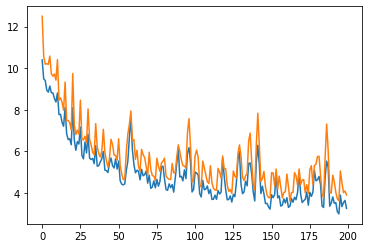

In [18]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


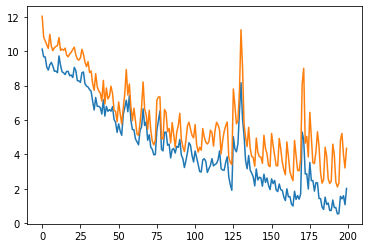

In [87]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


5


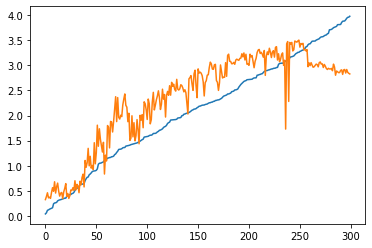

In [19]:
#loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
#loss_vals
print(nnodes)

ids_sort = np.argsort(y_curr);
pplot.plot(y_curr[ids_sort])
pplot.plot(prob_out.mean().numpy().flatten()[ids_sort])

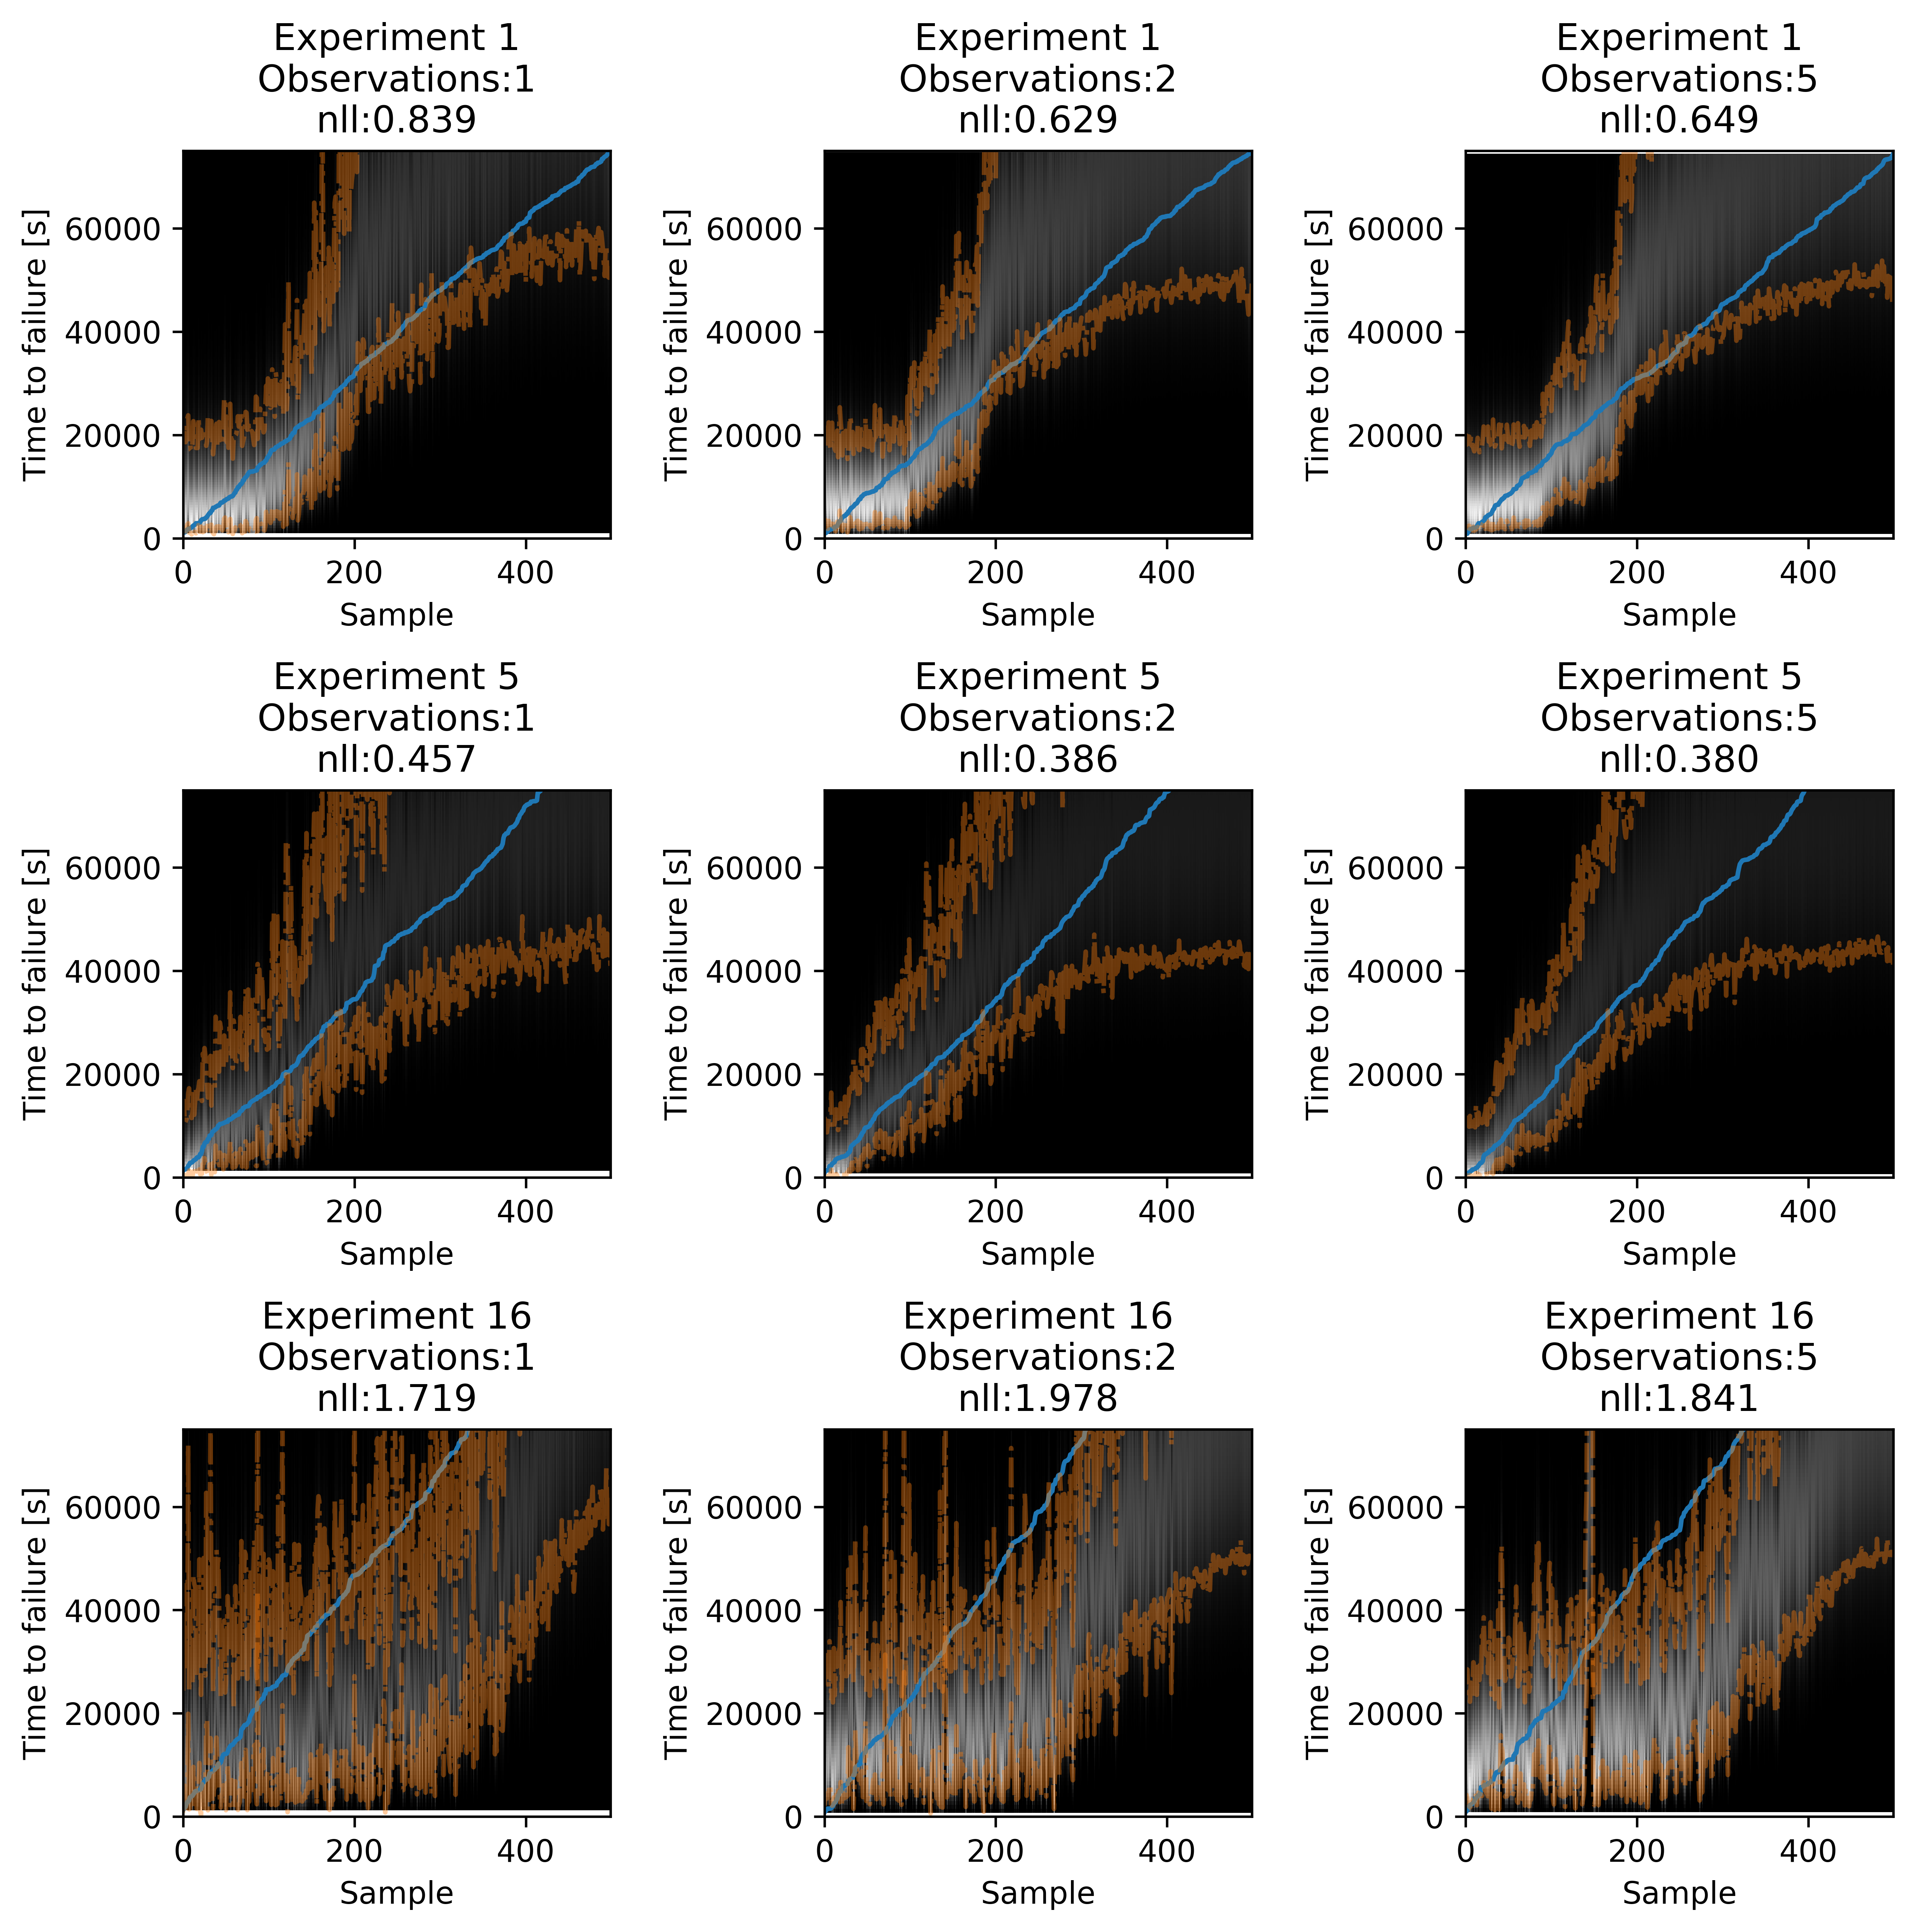

In [20]:
unseen = inds_exp_target[0:3]
training = inds_exp_source
nsampled = 500
nnodes = 5
ee = unseen[1]
ee = training[0]

pplot.figure(figsize = (10,10), dpi = 600)
nnodes_list = [1,2,5]
kk = 0;
for ee in unseen:
    for nnodes in nnodes_list:
        #ee = training[0]
        graphs, y_times = get_graph_data(ee, X_ = X, eid_oh_ = eid_oh,
                                         yrem_norm_ = yrem_norm, n_sampled_graphs = nsampled, 
                                         nnodes=nnodes, fixed_spacing=False, min_spacing=20)
        probs = eval_graphnets(graphs)
        #eval_graphnets()
        ids_sorted = np.argsort(y_times)
        time_grid = np.linspace(np.min(y_times),np.max(y_times), 150);
        #time_grid = np.linspace(np.min(y_times),3.5, 150);
        
        e_y = probs.mean()
        p_y = probs.prob(time_grid).numpy().T
        
        y_times_sorted = y_times[ids_sorted];
        pplot.subplot(len(unseen), len(nnodes_list), kk+1)
        pplot.pcolor([r for r in range(p_y.shape[1])], time_grid*normalization_factor_time, p_y[:,ids_sorted]**0.9, cmap = "gray")
        pplot.plot(y_times_sorted  *normalization_factor_time)
        q90 = np.quantile(probs.sample(1000).numpy(),[0.05,0.95],0)[:,:,0].T[ids_sorted]
        
        #pplot.plot(e_y.numpy()[ids_sorted]*normalization_factor_time,'C1',label = "$E[t_f]$",alpha = 0.5)
        pplot.plot(q90*normalization_factor_time,'C1-.', alpha = 0.4)
        pplot.ylim(0,75000)
        pplot.xlabel("Sample")
        pplot.ylabel("Time to failure [s]")

        nll = -np.mean(probs.log_prob(y_times[np.newaxis].T))

        title = "Experiment %i\n Observations:%i \nnll:%2.3f"%(ee,nnodes,nll)
        pplot.title(title)
        kk+=1
        #p_y.shape
        #pplot.show()
pplot.subplots_adjust(hspace = 0.65, wspace = 0.5)
pplot.show()

In [135]:
100000/normalization_factor_time

4.0

In [59]:

prob_out = eval_graphnets(graph_curr.copy())

In [ ]:
pplot.plot(loss_log.loss_history['val_loss'])

In [ ]:
from tqdm import tqdm
import time 
from IPython.display import clear_output
for i in tqdm(range(100)):
    time.sleep(0.1)
    print(i)
    clear_output()
    None

In [399]:
eval_graphnets(graph_dat[0][0])

<tfp.distributions.Gamma 'sequential_4_distribution_lambda_4_Gamma' batch_shape=[100, 1] event_shape=[] dtype=float32>

In [328]:
np.argmax(eid_oh_source,1)

array([ 0,  0,  0, ..., 15, 15, 15])

In [294]:
help(get_graph_data_multiple_experiments)

Help on function get_graph_data_multiple_experiments in module __main__:

get_graph_data_multiple_experiments(experiments, X_=None, eid_oh_=None, yrem_norm_=None, nsamples_per_experiment=100)

